## IMAGING BASED ASSAY DEVELOPMENT

by Anastasia Abashidze


Blavatnik Center for Drug Discovery
***

## Introduction
  
#### Phenotypic Screen for mitochondrial Modulators


<div align="justify"> In high content screening, cells are first incubated with the substance and after a period of time, structures and molecular components of the cells are analyzed. Through the use of fluorescent tags with different absorption and emission maxima, it is possible to measure several different cell components in parallel (e.g., cytoplasm vs. nucleus vs. other organelles). Therefore a large number of features can be collected per cell. </div>

<div align="justify"> In this experiment, we perform exploratory data analysis and developing an assay for screening for compounds that can activate or upregulate the numbers of mitochondria in the cell. To measure mitochondrial activity, we use TMRE (tetramethylrhodamine, ethyl ester). TMRE is a positively-charged red-orange dye that accumulates in active mitochondria due to their relative negative charge. Depolarized or inactive mitochondria have decreased membrane potential and fail to sequester TMRE. Hence, we can measure mitochondrial activity by normalized TMRE intensities (stored in the column 'Organelles Intensity-Bckg  wv3'), and mitochondrial numbers by normalized area (stored in the column 'Organelles Area'). Since we are interested in compounds that can modulate the behavior of mitochondria in a broad sense, we also exploring other features.</div>

#### PCA

<div align="justify"> PCA (Principal Component Analysis)is defined as an orthogonal linear transformation such that the greatest variance of the data by some scalar projection comes to lie on the first coordinate (first principal component, PC1) in a new coordinate system, the second greatest variance on the second coordinate (PC2), and so on. In such a way, PCA finds linear combinations of the features that separate different clusters and explain the behavior of the dependent variable (in our case mitochondria activation). PCA can be used for dimensionality reduction,  feature selection, noise filtering, and visualization of high-dimensional data. Here we use it to visualize 'phenotypic distance' between populations of cells with different treatments. </div>

#### Batch Effect

<div align="justify"> In molecular biology, a batch effect occurs when non-biological factors in an experiment cause changes in the data produced by the experiment. Such effects can lead to inaccurate conclusions when their causes are correlated with one or more outcomes of interest in an experiment.</div>

#### Assay Data

<div align="justify"> As previously, in this tutorial we analyze results obtained from image analysis software that accompanies automated confocal image reader (InCell Analyzer 2200). In this experiment, we test 3 compounds in different concentrations to select the best treatment to serve us as a positive control on the screen. The data is by cell data, and we will average it to obtain data per well or per field. </div>

## References

* High Content Screening (https://en.wikipedia.org/wiki/High-content_screening)
* PCA: https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c by Matt Brems
* Batch effect: https://en.wikipedia.org/wiki/Batch_effect
* Z-factor: https://en.wikipedia.org/wiki/Z-factor
***

## The Workflow

[Import Packages and create Output Folder](#import)   
[Load Data](#load_data)   
[Add Layout](#layout)   
[Explore Cell Counts](#cell_count)   
[Generate by Well Data](#by_well)   
[Run by Well Statistics](#stat)    
[PCA](#pca)   
[Generate by Field Data](#by_field)   
[Batch Effect](#batch)   
[Conclusions](#conclusions)   
 ***

### Import Packages and create Output Folder
<a id="import"></a>

In [33]:
from nbdev.showdoc import *
import os
import sys
sys.path.append('..//')
import pandas as pd
import numpy as np
from scipy import stats
import re
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context = 'notebook', style = 'white', palette = 'dark')
import simplydrug.core as sd

#### Create folder to save the output

In [34]:
path = ('image_dev_output') 
if not os.path.exists(path):
    os.mkdir(path)
    print('Output folder created')


#### Defining parameters

In [35]:
# path to data
data_path = 'hts_data//image_dev_data.csv'

# path to layout
layout_path = 'hts_data//image_dev_layout.xlsx'

### Load Data
<a id="load_data"></a>

In [36]:
data = pd.read_csv(data_path, low_memory = False)
print(data.shape)
display(data.head(3))

(133740, 48)


,OBJECT ID,Row,Column,FOV,WELL LABEL,Z,T,Class Name,Class Color,Ancestry Path,...,Organelles Intensity Spreading wv3,Organelles Intensity-Bckg wv3,Organelles Total Intensity-Bckg wv3,Organelles Distance to Nuc wv3,Organelles Spacing wv3,Organelles Neighbor Count wv3,Slice Algorithm,Slice Indicator,Acquisition Time Stamp,Plate ID
0,1,A,3,1,A - 3,1,1,NaN,NaN,NaN,...,0.900303,8566.866576,1.842326e+06,16.922745,3.125883,4.303030,CurrentSlice,Yes,0.0,Controls_48h
1,2,A,3,1,A - 3,1,1,NaN,NaN,NaN,...,0.898840,8731.233056,2.089788e+06,16.123873,2.835245,4.380282,CurrentSlice,Yes,0.0,Controls_48h
2,3,A,3,1,A - 3,1,1,NaN,NaN,NaN,...,0.868890,1873.898419,3.180743e+05,14.770907,2.772589,4.116667,CurrentSlice,Yes,0.0,Controls_48h


#### Add 'Field' column
Currently the field identifier are stored in the 'FOV' colummn. We will rename the 'WELL LABEL' column and create new 'Field' column which will contain both well and field identifiers.

In [37]:
data = data.rename(columns = {'WELL LABEL': 'Well'})
data.Well = [w.replace(' - ', '') for w in data.Well.values]

data['Field'] = data['Well'] + '_' + data['FOV'].astype(str)
display(data.head())

,OBJECT ID,Row,Column,FOV,Well,Z,T,Class Name,Class Color,Ancestry Path,...,Organelles Intensity-Bckg wv3,Organelles Total Intensity-Bckg wv3,Organelles Distance to Nuc wv3,Organelles Spacing wv3,Organelles Neighbor Count wv3,Slice Algorithm,Slice Indicator,Acquisition Time Stamp,Plate ID,Field
0,1,A,3,1,A3,1,1,NaN,NaN,NaN,...,8566.866576,1.842326e+06,16.922745,3.125883,4.303030,CurrentSlice,Yes,0.0,Controls_48h,A3_1
1,2,A,3,1,A3,1,1,NaN,NaN,NaN,...,8731.233056,2.089788e+06,16.123873,2.835245,4.380282,CurrentSlice,Yes,0.0,Controls_48h,A3_1
2,3,A,3,1,A3,1,1,NaN,NaN,NaN,...,1873.898419,3.180743e+05,14.770907,2.772589,4.116667,CurrentSlice,Yes,0.0,Controls_48h,A3_1
3,4,A,3,1,A3,1,1,NaN,NaN,NaN,...,3382.944979,6.460410e+05,14.994054,3.213694,4.660194,CurrentSlice,Yes,0.0,Controls_48h,A3_1
4,5,A,3,1,A3,1,1,NaN,NaN,NaN,...,2372.237913,4.104298e+05,15.231269,2.868072,4.372549,CurrentSlice,Yes,0.0,Controls_48h,A3_1


#### Drop and rename some columns, and replace slash character in column names

In [38]:
data = data.drop(columns = ['FOV', 'OBJECT ID', 'Row', 'Column', 'Z', 'T', 'Class Name', 'Class Color', 'Ancestry Path','Slice Algorithm', 'Slice Indicator', 'Acquisition Time Stamp', 'Plate ID' ])


#Replace slash
cols = [c.replace('/', '_') for c in list(data)]
data.columns = cols
print(list(data))


display(data.head(3))

['Well', 'Nuclei Max left border wv1', 'Nuclei Max top border wv1', 'Nuclei Max width wv1', 'Nuclei Max height wv1', 'Nuclei Area wv1', 'Nuclei Intensity wv1', 'Nuclei Max Intensity wv1', 'Cells Max left border wv2', 'Cells Max top border wv2', 'Cells Max width wv2', 'Cells Max height wv2', 'Cells Area wv2', 'Cells Intensity (Cell) wv2', 'Cells Max Intensity wv2', 'Organelles Org per Cell wv3', 'Organelles Area  wv3', 'Organelles Total Area wv3', 'Organelles Form Factor  wv3', 'Organelles Elongation  wv3', 'Organelles Compactness wv3', 'Organelles Chord Ratio wv3', 'Organelles Gyration Radius  wv3', 'Organelles Intensity wv3', 'Organelles Total Intensity  wv3', 'Organelles Intensity CV wv3', 'Organelles Organelle_Cyto Intensity wv3', 'Organelles Organelle_Bckg Intensity  wv3', 'Organelles Intensity_Global Bckg  wv3', 'Organelles Intensity Spreading wv3', 'Organelles Intensity-Bckg  wv3', 'Organelles Total Intensity-Bckg wv3', 'Organelles Distance to Nuc  wv3', 'Organelles Spacing  wv3'

,Well,Nuclei Max left border wv1,Nuclei Max top border wv1,Nuclei Max width wv1,Nuclei Max height wv1,Nuclei Area wv1,Nuclei Intensity wv1,Nuclei Max Intensity wv1,Cells Max left border wv2,Cells Max top border wv2,...,Organelles Organelle_Cyto Intensity wv3,Organelles Organelle_Bckg Intensity wv3,Organelles Intensity_Global Bckg wv3,Organelles Intensity Spreading wv3,Organelles Intensity-Bckg wv3,Organelles Total Intensity-Bckg wv3,Organelles Distance to Nuc wv3,Organelles Spacing wv3,Organelles Neighbor Count wv3,Field
0,A3,1012.0,26.0,58.0,75.0,313.811875,957.931336,1825.0,914.0,0.0,...,1.697006,14.593597,14.904249,0.900303,8566.866576,1.842326e+06,16.922745,3.125883,4.303030,A3_1
1,A3,1125.0,123.0,60.0,71.0,301.770625,913.426671,1910.0,1080.0,32.0,...,1.653011,14.583453,15.190984,0.898840,8731.233056,2.089788e+06,16.123873,2.835245,4.380282,A3_1
2,A3,1318.0,149.0,53.0,72.0,318.036875,1159.926270,2247.0,1227.0,112.0,...,1.737999,4.033988,4.037634,0.868890,1873.898419,3.180743e+05,14.770907,2.772589,4.116667,A3_1


### Add Layout
<a id="layout"></a>

In [39]:
data = sd.add_layout(df = data, layout_path = layout_path , chem_path = None, chem_plate = None)
display(data.head())

Added  Well
Added  Treatment
Added  Status
Chemical library not requested


,Well,Nuclei Max left border wv1,Nuclei Max top border wv1,Nuclei Max width wv1,Nuclei Max height wv1,Nuclei Area wv1,Nuclei Intensity wv1,Nuclei Max Intensity wv1,Cells Max left border wv2,Cells Max top border wv2,...,Organelles Intensity_Global Bckg wv3,Organelles Intensity Spreading wv3,Organelles Intensity-Bckg wv3,Organelles Total Intensity-Bckg wv3,Organelles Distance to Nuc wv3,Organelles Spacing wv3,Organelles Neighbor Count wv3,Field,Treatment,Status
0,A3,1012.0,26.0,58.0,75.0,313.811875,957.931336,1825.0,914.0,0.0,...,14.904249,0.900303,8566.866576,1.842326e+06,16.922745,3.125883,4.303030,A3_1,DMSO,Sample
1,A3,1125.0,123.0,60.0,71.0,301.770625,913.426671,1910.0,1080.0,32.0,...,15.190984,0.898840,8731.233056,2.089788e+06,16.123873,2.835245,4.380282,A3_1,DMSO,Sample
2,A3,1318.0,149.0,53.0,72.0,318.036875,1159.926270,2247.0,1227.0,112.0,...,4.037634,0.868890,1873.898419,3.180743e+05,14.770907,2.772589,4.116667,A3_1,DMSO,Sample
3,A3,758.0,170.0,56.0,58.0,251.915625,814.198323,1307.0,690.0,74.0,...,6.466973,0.918532,3382.944979,6.460410e+05,14.994054,3.213694,4.660194,A3_1,DMSO,Sample
4,A3,961.0,187.0,58.0,67.0,300.186250,1120.903589,2122.0,898.0,138.0,...,4.846989,0.878134,2372.237913,4.104298e+05,15.231269,2.868072,4.372549,A3_1,DMSO,Sample


#### Drop empty wells

In [40]:
data = data.copy().dropna(subset = ['Treatment']).fillna(0)
print(data.shape)

(106193, 38)


#### Print column names

In [41]:
print(list(data))

['Well', 'Nuclei Max left border wv1', 'Nuclei Max top border wv1', 'Nuclei Max width wv1', 'Nuclei Max height wv1', 'Nuclei Area wv1', 'Nuclei Intensity wv1', 'Nuclei Max Intensity wv1', 'Cells Max left border wv2', 'Cells Max top border wv2', 'Cells Max width wv2', 'Cells Max height wv2', 'Cells Area wv2', 'Cells Intensity (Cell) wv2', 'Cells Max Intensity wv2', 'Organelles Org per Cell wv3', 'Organelles Area  wv3', 'Organelles Total Area wv3', 'Organelles Form Factor  wv3', 'Organelles Elongation  wv3', 'Organelles Compactness wv3', 'Organelles Chord Ratio wv3', 'Organelles Gyration Radius  wv3', 'Organelles Intensity wv3', 'Organelles Total Intensity  wv3', 'Organelles Intensity CV wv3', 'Organelles Organelle_Cyto Intensity wv3', 'Organelles Organelle_Bckg Intensity  wv3', 'Organelles Intensity_Global Bckg  wv3', 'Organelles Intensity Spreading wv3', 'Organelles Intensity-Bckg  wv3', 'Organelles Total Intensity-Bckg wv3', 'Organelles Distance to Nuc  wv3', 'Organelles Spacing  wv3'

#### Select features columns

In [42]:
# Take columns with numerical values as fatures
Features = list(data)[1:-3]
print(list(Features ))

['Nuclei Max left border wv1', 'Nuclei Max top border wv1', 'Nuclei Max width wv1', 'Nuclei Max height wv1', 'Nuclei Area wv1', 'Nuclei Intensity wv1', 'Nuclei Max Intensity wv1', 'Cells Max left border wv2', 'Cells Max top border wv2', 'Cells Max width wv2', 'Cells Max height wv2', 'Cells Area wv2', 'Cells Intensity (Cell) wv2', 'Cells Max Intensity wv2', 'Organelles Org per Cell wv3', 'Organelles Area  wv3', 'Organelles Total Area wv3', 'Organelles Form Factor  wv3', 'Organelles Elongation  wv3', 'Organelles Compactness wv3', 'Organelles Chord Ratio wv3', 'Organelles Gyration Radius  wv3', 'Organelles Intensity wv3', 'Organelles Total Intensity  wv3', 'Organelles Intensity CV wv3', 'Organelles Organelle_Cyto Intensity wv3', 'Organelles Organelle_Bckg Intensity  wv3', 'Organelles Intensity_Global Bckg  wv3', 'Organelles Intensity Spreading wv3', 'Organelles Intensity-Bckg  wv3', 'Organelles Total Intensity-Bckg wv3', 'Organelles Distance to Nuc  wv3', 'Organelles Spacing  wv3', 'Organ

### Explore Cell Counts
<a id="cell_count"></a>

In [43]:
counts = pd.DataFrame()
counts['Counts_well'] = data.groupby('Well').size() # Count number of rows for each well
print(counts.min())

Counts_well    13
dtype: int64


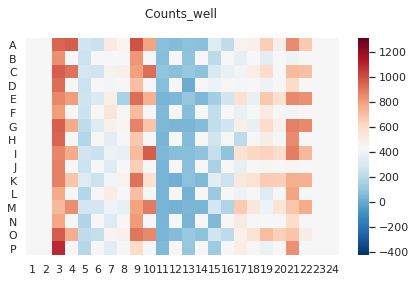

In [44]:
sd.hts_heatmap(counts, layout_path, ['Counts_well'], path)

It seems that some compounds are toxic. As we can see from the layout (see below) compound 3 is cytotoxic at all concentrations (columns 11-16), compound 2 is less toxic (columns 5-10), and and compound 1 is the best choice from the point of view of toxicity.

In [45]:
# show layout
treatments_map = pd.ExcelFile(layout_path).parse('Treatment')
display(treatments_map)

,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
0,NaN,NaN,DMSO,DMSO,Compound2_30nM,Compound2_30nM,Compound2_10nM,Compound2_10nM,Compound2_1nM,Compound2_1nM,...,Compound3_2uM,Compound3_2uM,Compound1_8mM,Compound1_8mM,Compound1_5mM,Compound1_5mM,Compound1_2mM,Compound1_2mM,NaN,NaN
1,NaN,NaN,DMSO,NaN,Compound2_30nM,NaN,Compound2_10nM,NaN,Compound2_1nM,NaN,...,Compound3_2uM,NaN,Compound1_8mM,NaN,Compound1_5mM,NaN,Compound1_2mM,NaN,NaN,NaN
2,NaN,NaN,DMSO,DMSO,Compound2_30nM,Compound2_30nM,Compound2_10nM,Compound2_10nM,Compound2_1nM,Compound2_1nM,...,Compound3_2uM,Compound3_2uM,Compound1_8mM,Compound1_8mM,Compound1_5mM,Compound1_5mM,Compound1_2mM,Compound1_2mM,NaN,NaN
3,NaN,NaN,DMSO,NaN,Compound2_30nM,NaN,Compound2_10nM,NaN,Compound2_1nM,NaN,...,Compound3_2uM,NaN,Compound1_8mM,NaN,Compound1_5mM,NaN,Compound1_2mM,NaN,NaN,NaN
4,NaN,NaN,DMSO,DMSO,Compound2_30nM,Compound2_30nM,Compound2_10nM,Compound2_10nM,Compound2_1nM,Compound2_1nM,...,Compound3_2uM,Compound3_2uM,Compound1_8mM,Compound1_8mM,Compound1_5mM,Compound1_5mM,Compound1_2mM,Compound1_2mM,NaN,NaN
5,NaN,NaN,DMSO,NaN,Compound2_30nM,NaN,Compound2_10nM,NaN,Compound2_1nM,NaN,...,Compound3_2uM,NaN,Compound1_8mM,NaN,Compound1_5mM,NaN,Compound1_2mM,NaN,NaN,NaN
6,NaN,NaN,DMSO,DMSO,Compound2_30nM,Compound2_30nM,Compound2_10nM,Compound2_10nM,Compound2_1nM,Compound2_1nM,...,Compound3_2uM,Compound3_2uM,Compound1_8mM,Compound1_8mM,Compound1_5mM,Compound1_5mM,Compound1_2mM,Compound1_2mM,NaN,NaN
7,NaN,NaN,DMSO,NaN,Compound2_30nM,NaN,Compound2_10nM,NaN,Compound2_1nM,NaN,...,Compound3_2uM,NaN,Compound1_8mM,NaN,Compound1_5mM,NaN,Compound1_2mM,NaN,NaN,NaN
8,NaN,NaN,DMSO,DMSO,Compound2_30nM,Compound2_30nM,Compound2_10nM,Compound2_10nM,Compound2_1nM,Compound2_1nM,...,Compound3_2uM,Compound3_2uM,Compound1_8mM,Compound1_8mM,Compound1_5mM,Compound1_5mM,Compound1_2mM,Compound1_2mM,NaN,NaN
9,NaN,NaN,DMSO,NaN,Compound2_30nM,NaN,Compound2_10nM,NaN,Compound2_1nM,NaN,...,Compound3_2uM,NaN,Compound1_8mM,NaN,Compound1_5mM,NaN,Compound1_2mM,NaN,NaN,NaN


### Generate by Well Data
<a id="by_well"></a>

In [46]:
descriptors = data[['Well', 'Treatment','Status']]
Features.extend(['Well']) # add 'Well' to Features
measurements = data[Features]

results_well = pd.DataFrame()

for name, group in measurements.groupby('Well'):
    m = group.mean()
    m['Well'] = name
    results_well  = results_well.append(m, ignore_index = True )

results_well = pd.merge(results_well.copy(), descriptors.drop_duplicates(), how = 'left', on = 'Well')
print(results_well.shape)
display(results_well.head())

(240, 37)


,Cells Area wv2,Cells Intensity (Cell) wv2,Cells Max Intensity wv2,Cells Max height wv2,Cells Max left border wv2,Cells Max top border wv2,Cells Max width wv2,Nuclei Area wv1,Nuclei Intensity wv1,Nuclei Max Intensity wv1,...,Organelles Org per Cell wv3,Organelles Organelle_Bckg Intensity wv3,Organelles Organelle_Cyto Intensity wv3,Organelles Spacing wv3,Organelles Total Area wv3,Organelles Total Intensity wv3,Organelles Total Intensity-Bckg wv3,Well,Treatment,Status
0,1906.257742,14954.439894,40105.256927,179.801008,975.055416,1018.818640,176.438287,250.209262,851.390575,1570.952141,...,87.290932,5.558428,1.242483,3.152885,149.088224,7.715758e+05,653785.934428,A10,Compound2_1nM,Sample
1,1276.482294,19155.263715,50089.052632,135.473684,1012.315789,854.618421,138.842105,235.567377,1175.747254,2631.381579,...,78.526316,12.819041,1.318331,2.581646,145.094005,8.545484e+05,797689.489105,A11,Compound3_8uM,Sample
2,1321.692331,19893.255484,48967.777778,143.666667,1086.730159,811.730159,136.952381,213.899008,1182.297769,2630.238095,...,84.444444,12.942090,1.312220,2.856922,157.770218,8.883646e+05,828159.622872,A12,Compound3_8uM,Sample
3,1296.353022,18654.257304,47960.600000,136.576471,1006.635294,995.729412,128.741176,259.846199,1167.107723,2528.129412,...,81.870588,11.236810,1.212329,2.753330,146.903250,7.249516e+05,667073.657594,A13,Compound3_5uM,Sample
4,1397.862375,21449.790761,50567.437500,143.850000,1058.025000,931.250000,142.612500,281.513070,1159.670780,2537.862500,...,92.537500,14.046976,1.227290,2.876877,163.062555,1.022595e+06,954855.346259,A14,Compound3_5uM,Sample


#### Create some new feature
(Optionally)

In [47]:

results_well['org_int_area'] = results_well['Organelles Intensity-Bckg  wv3']*results_well['Organelles Area  wv3']

In [48]:
# Take columns with numerical values as features
Features = list(data)[2:-3]
new_features = ['org_int_area']
Features.extend(new_features)

In [49]:
print(data.Treatment.unique())

['DMSO' 'Compound2_30nM' 'Compound2_10nM' 'Compound2_1nM' 'Compound3_8uM'
 'Compound3_5uM' 'Compound3_2uM' 'Compound1_8mM' 'Compound1_5mM'
 'Compound1_2mM']


#### Plot treatments

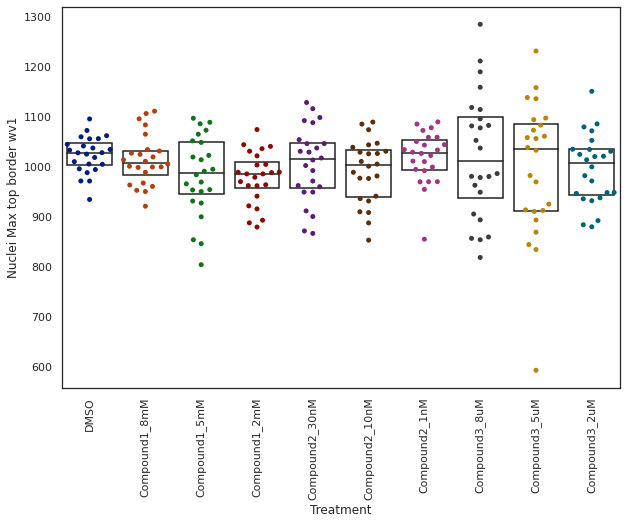

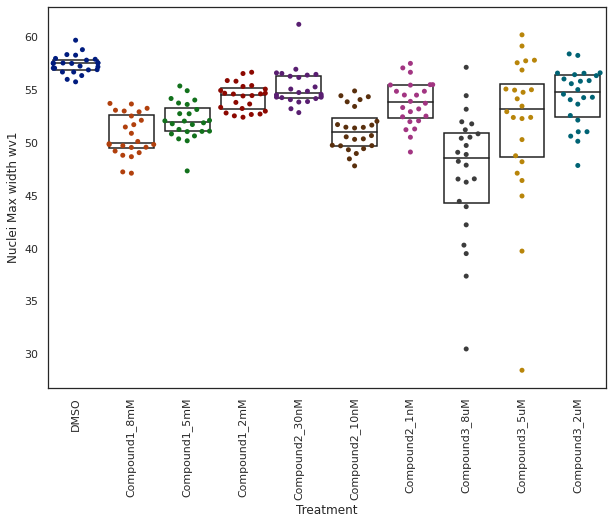

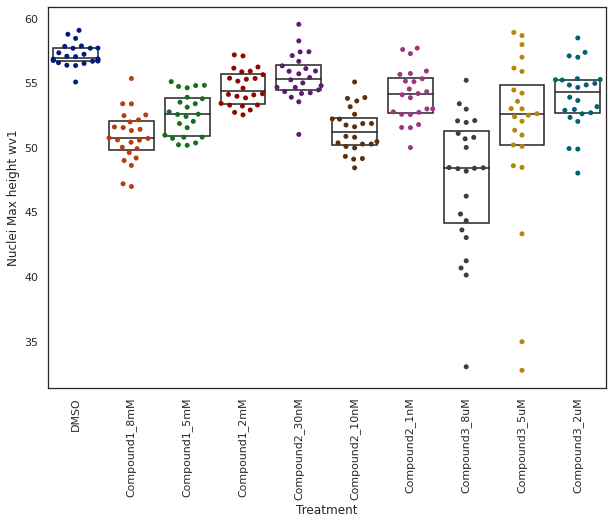

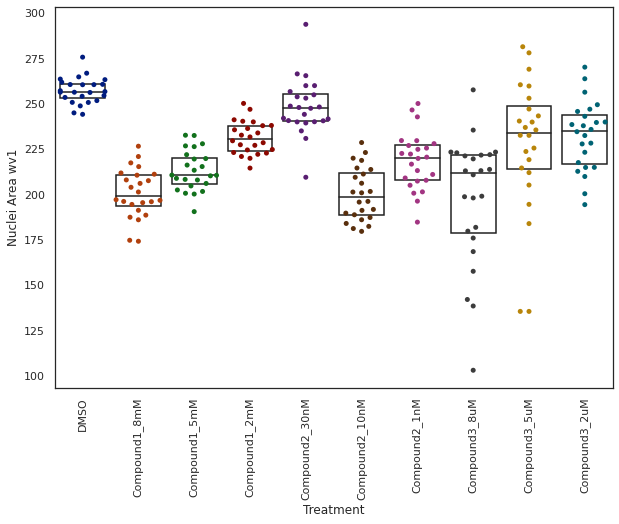

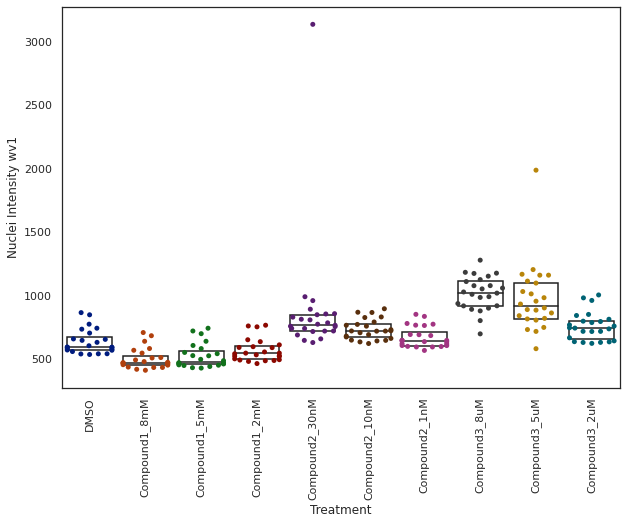

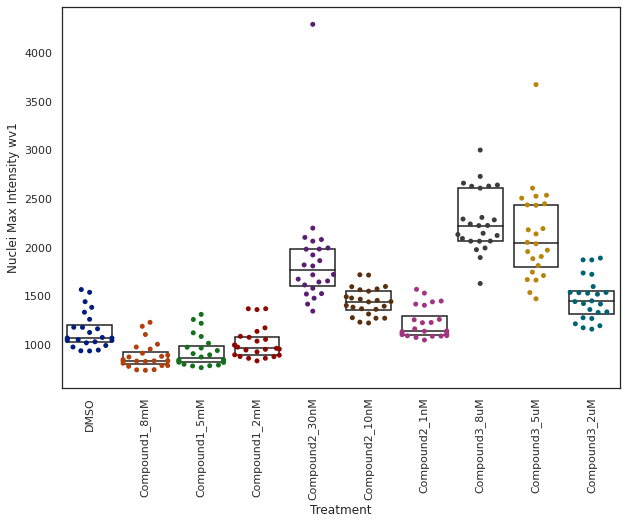

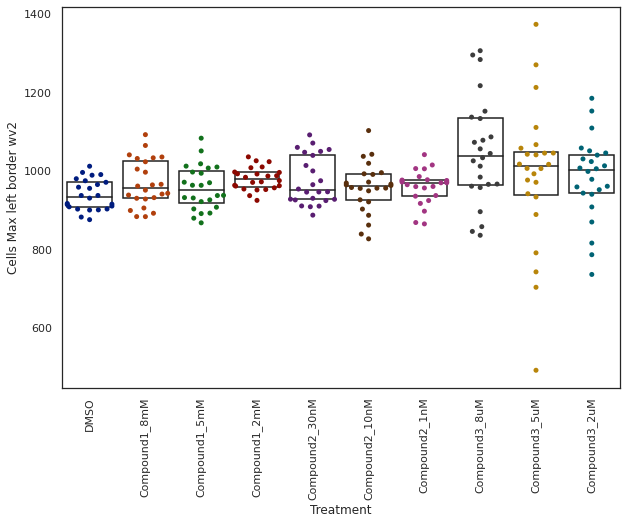

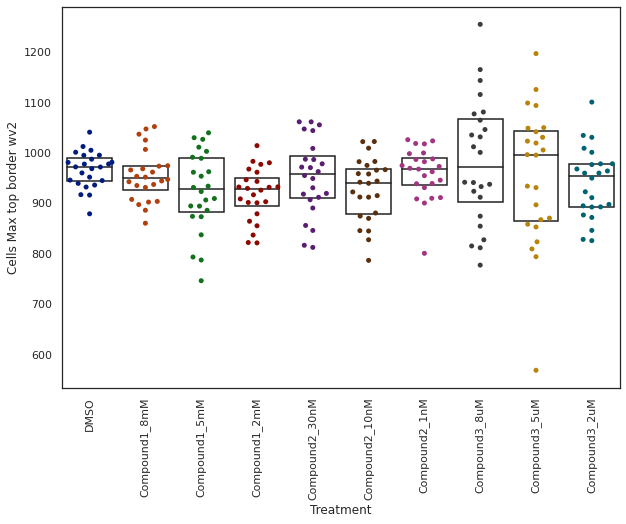

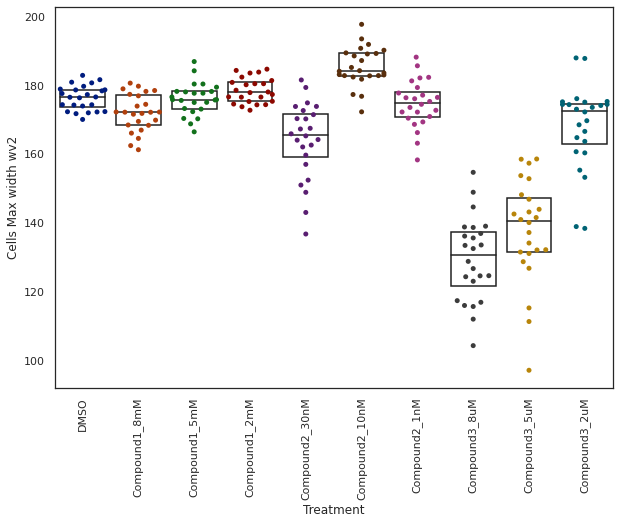

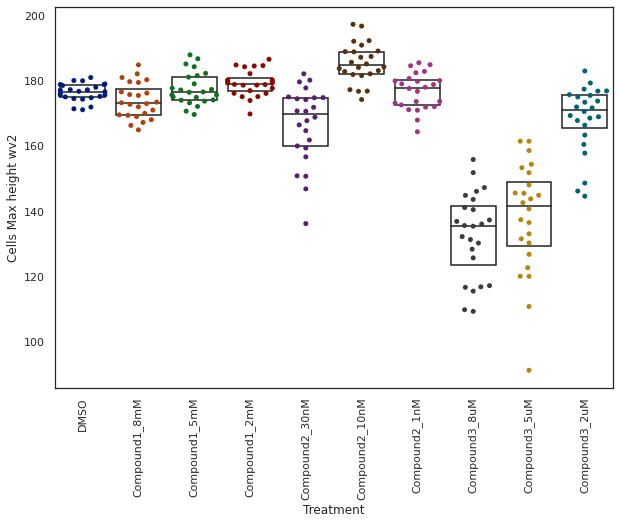

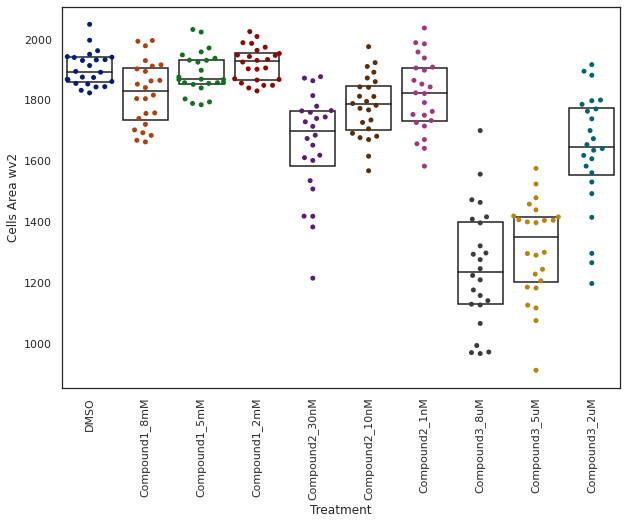

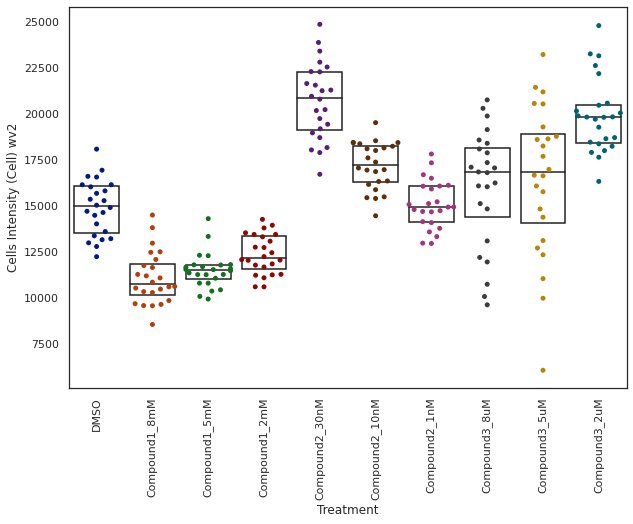

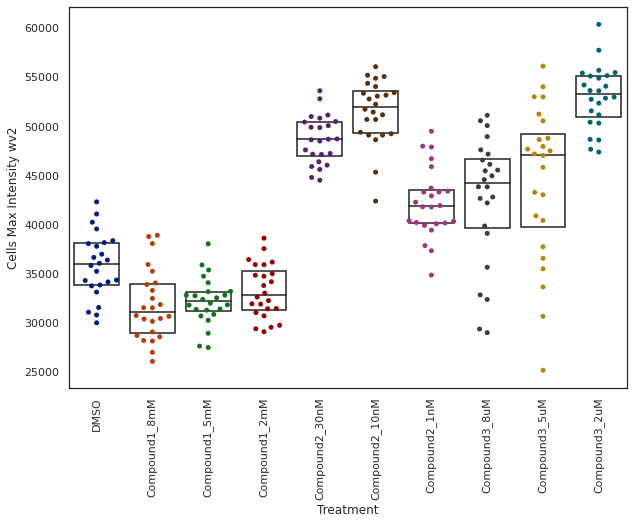

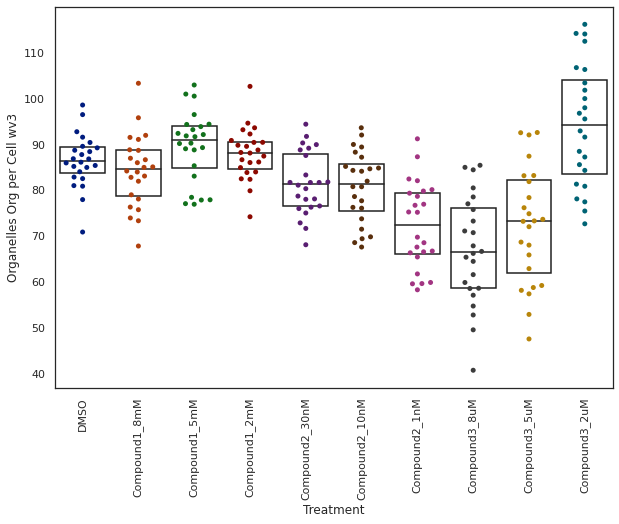

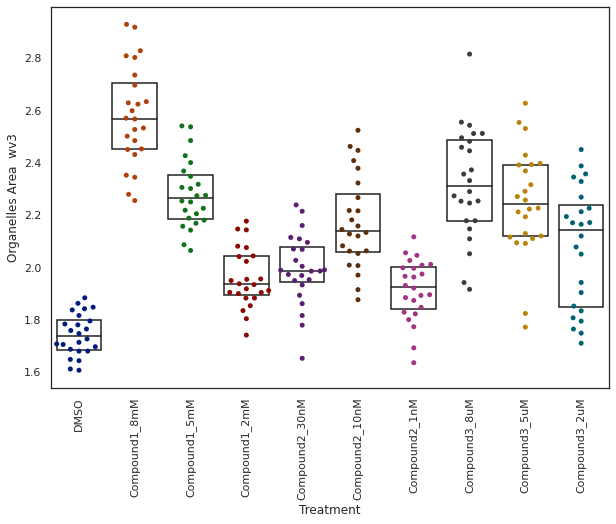

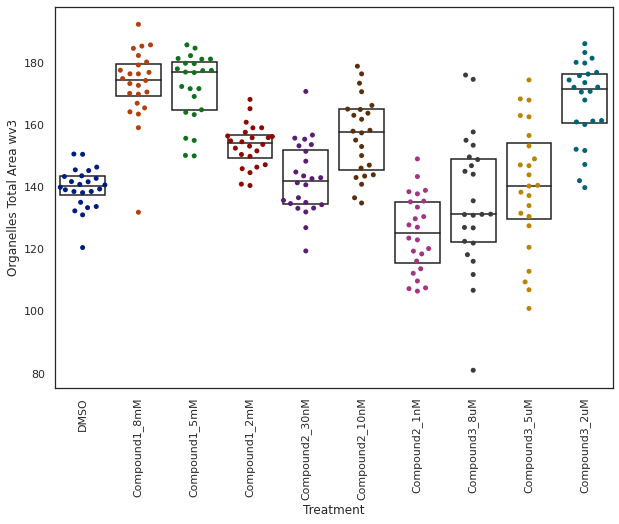

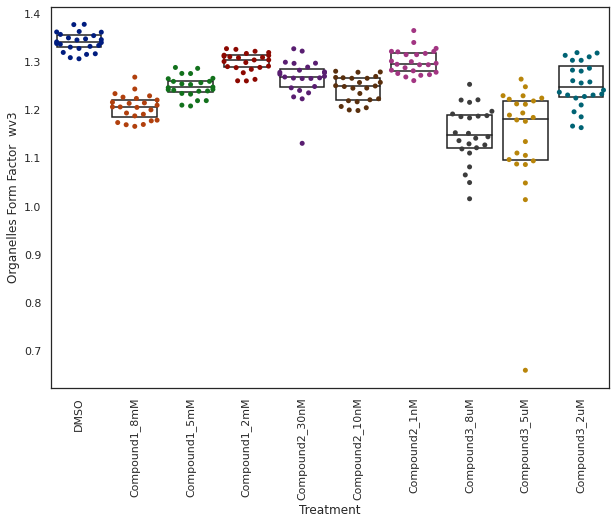

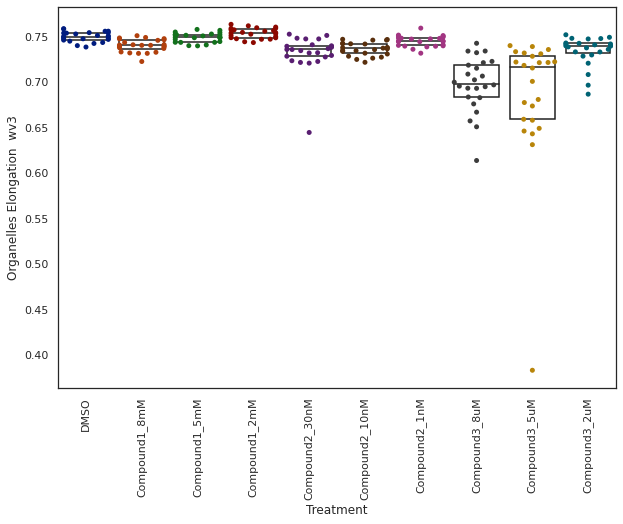

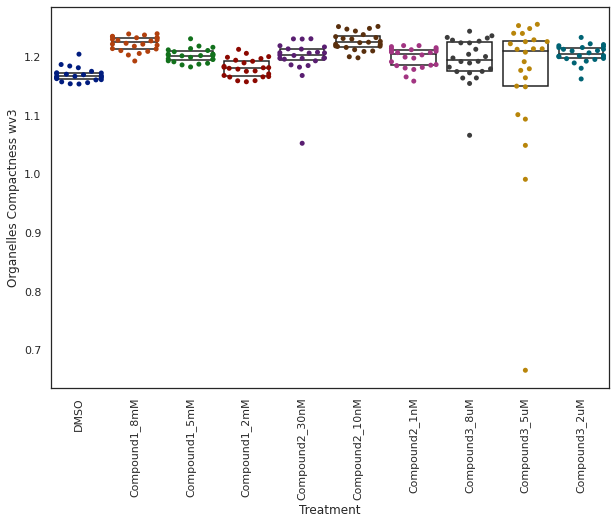

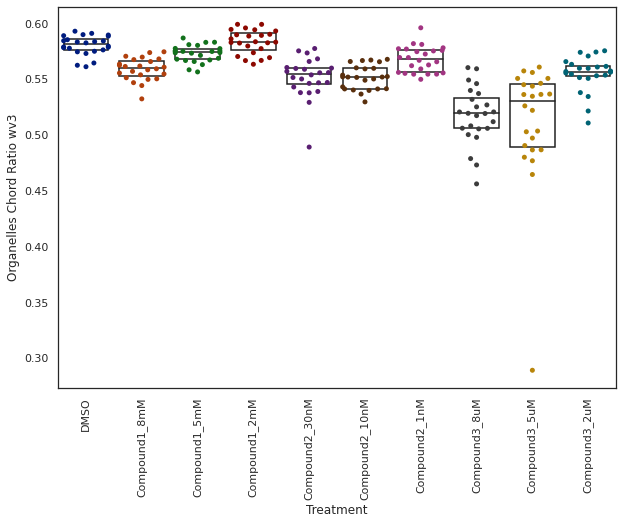

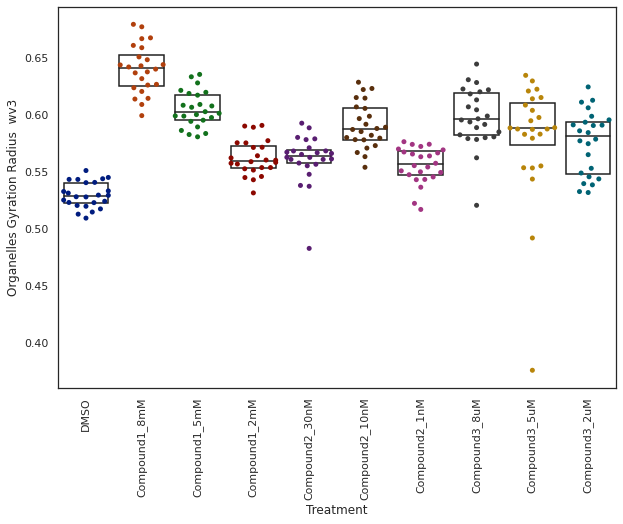

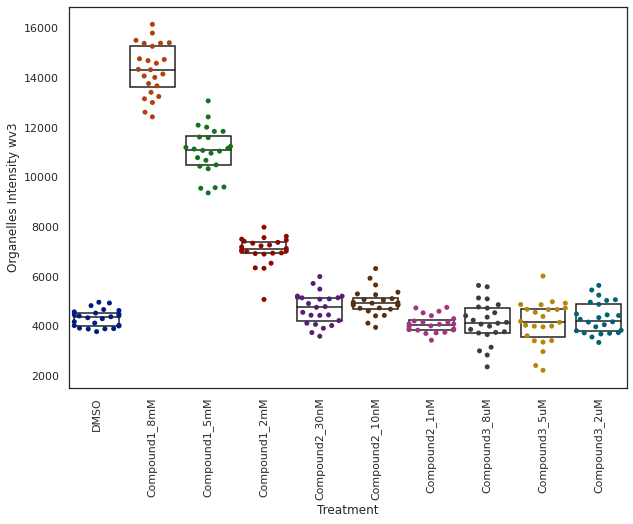

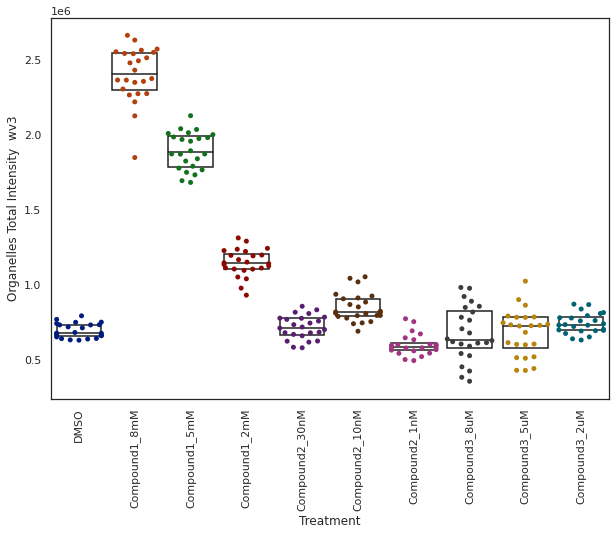

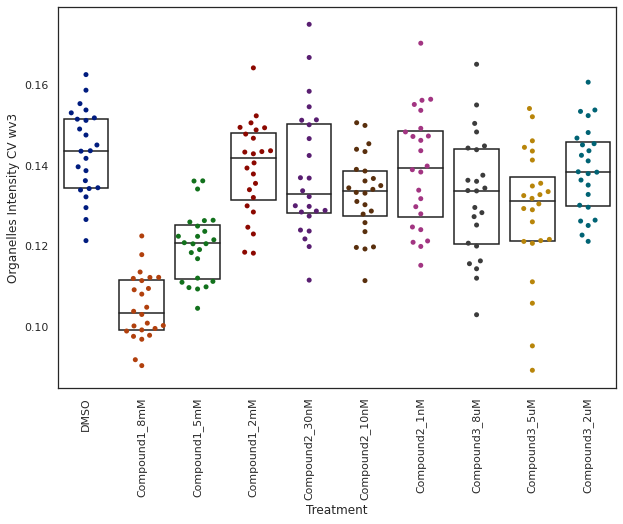

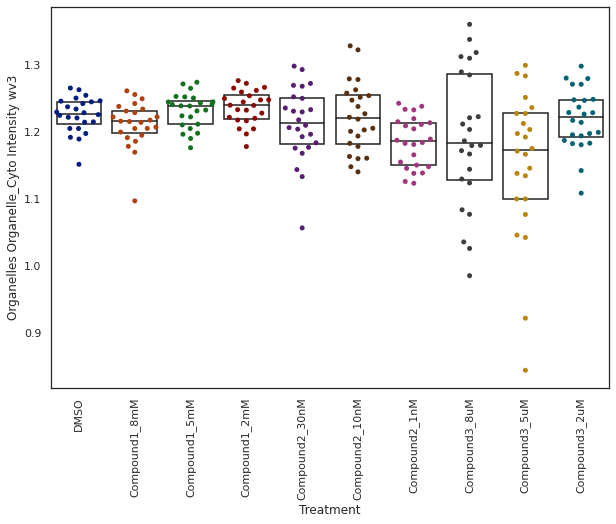

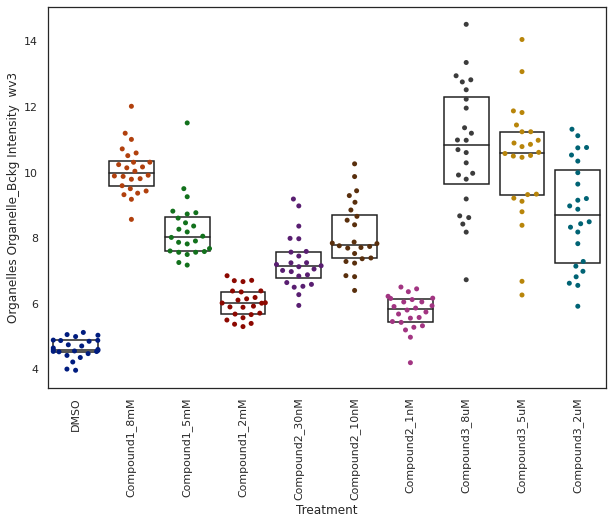

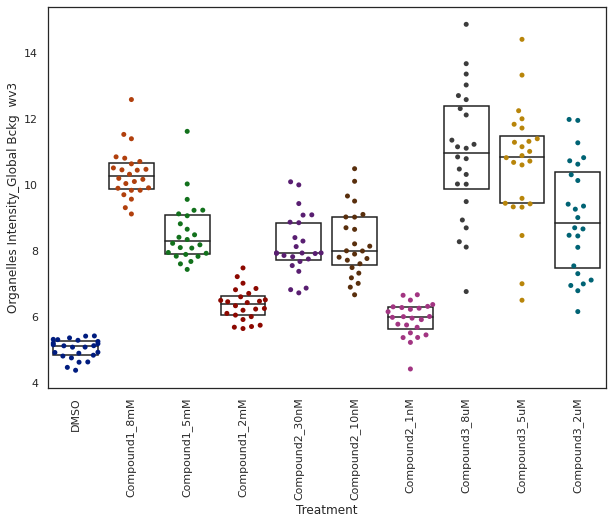

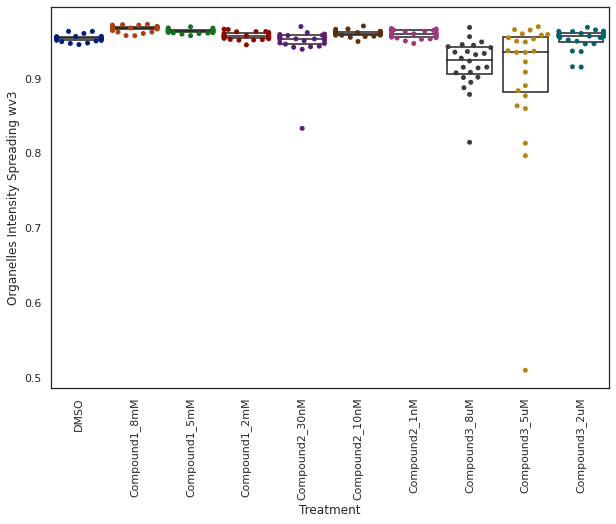

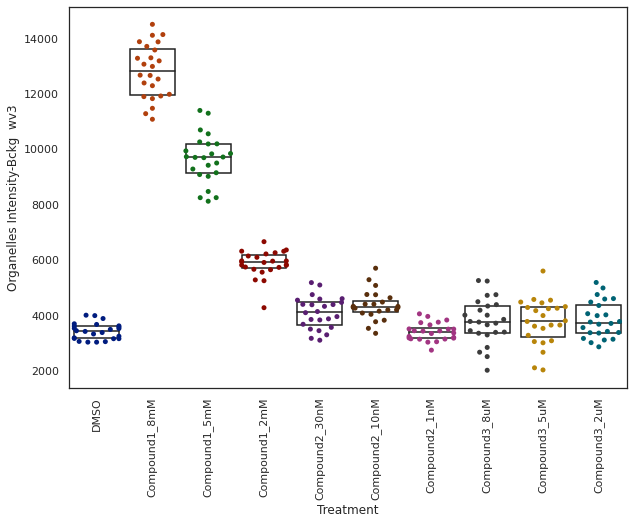

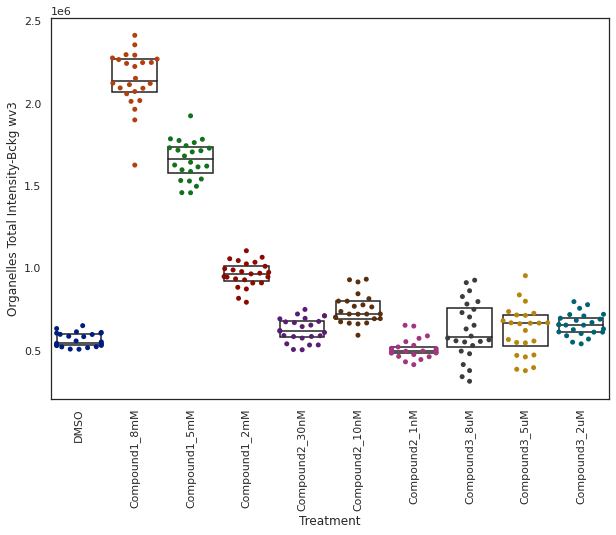

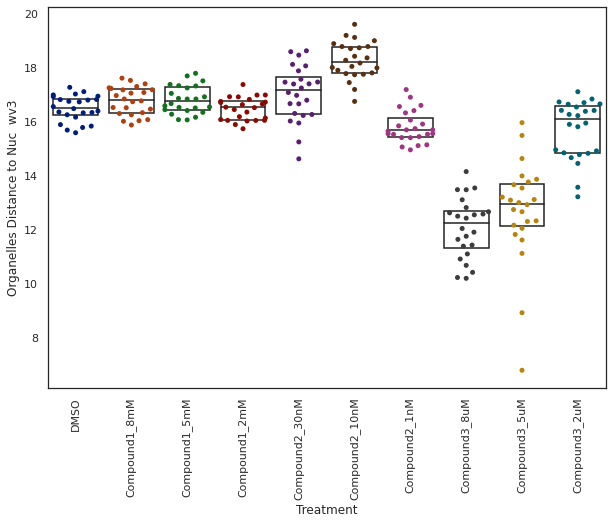

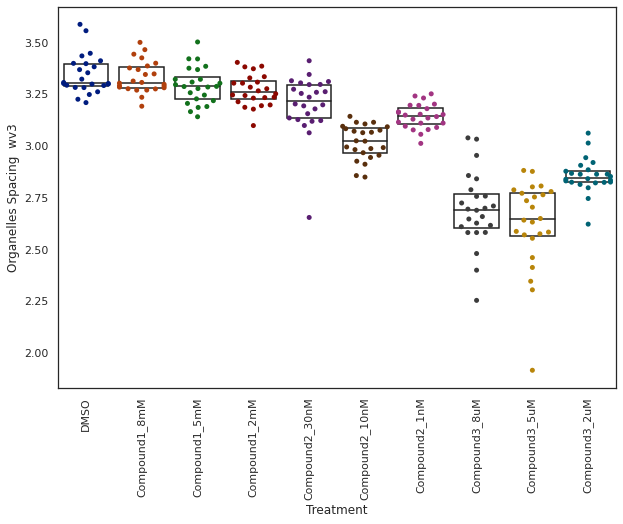

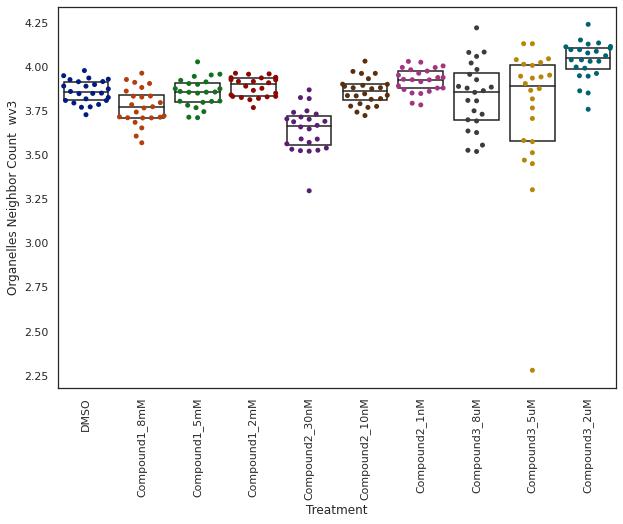

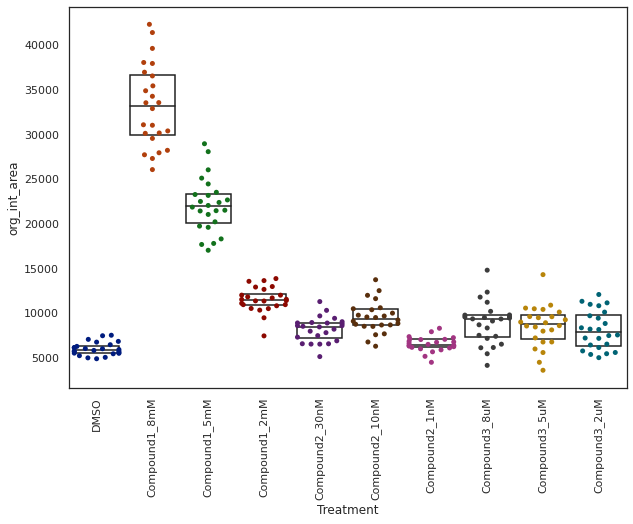

In [50]:
my_order = ['DMSO', 'Compound1_8mM', 'Compound1_5mM', 'Compound1_2mM', 'Compound2_30nM', 'Compound2_10nM', 
            'Compound2_1nM', 'Compound3_8uM', 'Compound3_5uM', 'Compound3_2uM']
for f in Features:

    ax = sns.swarmplot(x = 'Treatment', y = f, data = results_well, order = my_order)
    ax = sns.boxplot('Treatment', y = f, data = results_well, order = my_order, showcaps  = False,boxprops = {'facecolor':'None'},
                      showfliers = False, whiskerprops = {'linewidth':0})
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    fig = ax.get_figure()
    fig.set_size_inches(10, 7)
    plt.savefig(path + '//' + f + '_well_plot', bbox_inches = 'tight', dpi = 600)
    
    plt.show()

### Run by Well Statistics on selected Features
<a id="stat"></a>

To select compound and concentration which can serve as positive control in the screen, we will calculate statistics for each treatment. 

In [51]:
selected_features = ['Organelles Intensity-Bckg  wv3', 'Organelles Area  wv3','Organelles Form Factor  wv3', 
                     'Organelles Org per Cell wv3', 'Organelles Total Area wv3', 
                     'org_int_area' ]

In [52]:
Compound1_8mM = results_well[results_well.Treatment == 'Compound1_8mM'].copy()
Compound1_5mM = results_well[results_well.Treatment == 'Compound1_5mM'].copy()
Compound1_2mM = results_well[results_well.Treatment == 'Compound1_2mM'].copy()
Compound2_30nM = results_well[results_well.Treatment == 'Compound2_30nM'].copy()
Compound2_10nM = results_well[results_well.Treatment == 'Compound2_10nM'].copy()
Compound2_1nM = results_well[results_well.Treatment == 'Compound2_1nM'].copy()
Compound3_8uM = results_well[results_well.Treatment == 'Compound3_8uM'].copy()
Compound3_5uM = results_well[results_well.Treatment == 'Compound3_5uM'].copy()
Compound3_2uM = results_well[results_well.Treatment == 'Compound3_2uM'].copy()
DMSO = results_well[results_well.Treatment == 'DMSO'].copy()

Treatments = [Compound1_8mM, Compound1_5mM, Compound1_2mM, Compound2_30nM, Compound2_10nM, Compound2_1nM,
             Compound3_8uM, Compound3_5uM, Compound3_2uM]

In [53]:
# Change status
DMSO['Status'] = 'Negative'

for t in Treatments:
    t['Status'] = 'Positive' 

print(Compound1_8mM.shape)
display(Compound1_8mM.head())

(24, 38)


,Cells Area wv2,Cells Intensity (Cell) wv2,Cells Max Intensity wv2,Cells Max height wv2,Cells Max left border wv2,Cells Max top border wv2,Cells Max width wv2,Nuclei Area wv1,Nuclei Intensity wv1,Nuclei Max Intensity wv1,...,Organelles Organelle_Bckg Intensity wv3,Organelles Organelle_Cyto Intensity wv3,Organelles Spacing wv3,Organelles Total Area wv3,Organelles Total Intensity wv3,Organelles Total Intensity-Bckg wv3,Well,Treatment,Status,org_int_area
7,1853.066874,8574.129650,26106.750000,170.012712,1064.927966,897.506356,172.243644,206.184252,682.942628,1190.949153,...,10.164601,1.194873,3.313107,164.254707,2.365211e+06,2.123456e+06,A17,Compound1_8mM,Positive,33575.530445
8,1916.556553,9590.626520,28237.265849,173.439673,964.674847,953.541922,174.527607,210.704163,707.913976,1231.887526,...,9.366031,1.217377,3.425097,176.483391,2.375097e+06,2.094381e+06,A18,Compound1_8mM,Positive,31040.953360
23,1930.502014,9664.168907,27029.473829,175.757576,1004.873278,944.449036,171.887052,226.678815,639.089828,1107.079890,...,8.567939,1.096854,3.191599,131.907002,1.847806e+06,1.626112e+06,B17,Compound1_8mM,Positive,27319.406582
37,1993.842461,11102.607051,32513.457627,180.978208,932.263923,860.484262,180.697337,215.436126,546.075375,957.171913,...,11.004037,1.178233,3.269203,165.524094,2.273843e+06,2.058905e+06,C17,Compound1_8mM,Positive,32904.079483
38,1996.500697,9702.554423,29105.128968,179.706349,938.841270,903.791667,178.545635,211.253144,568.246682,978.488095,...,9.319383,1.204897,3.276090,180.311306,2.356076e+06,2.092363e+06,C18,Compound1_8mM,Positive,27958.870271


In [54]:
# calculate statisticss
all_stat = pd.DataFrame()

for t in Treatments:
    current_data = t.append(DMSO)
    current_data.name = current_data['Treatment'].values[0]
    for f in selected_features:
            stat = sd.sum_statistics(df =  current_data, feature = f)
            stat['Treatment'] = current_data.name
            all_stat = all_stat.append(stat)
all_stat.to_csv(path + '//sum_statistics_well.csv', index = False)
all_stat = all_stat[['Treatment', 'Feature', 'Status', 'size', 'mean', 'std', 'var', 'Z_factor', 'SB']]
display(all_stat.shape)

(108, 9)

In [55]:
all_stat = all_stat.sort_values('Z_factor', ascending  = False)
display(all_stat[0:20])

,Treatment,Feature,Status,size,mean,std,var,Z_factor,SB
0,Compound1_8mM,Organelles Intensity-Bckg wv3,Negative,24.0,3433.838239,295.823357,8.751146e+04,0.595257,3.733547
1,Compound1_8mM,Organelles Intensity-Bckg wv3,Positive,24.0,12820.397196,970.556704,9.419803e+05,0.595257,3.733547
1,Compound1_5mM,Organelles Intensity-Bckg wv3,Positive,24.0,9652.763871,875.307474,7.661632e+05,0.435048,2.811071
0,Compound1_5mM,Organelles Intensity-Bckg wv3,Negative,24.0,3433.838239,295.823357,8.751146e+04,0.435048,2.811071
0,Compound1_8mM,org_int_area,Negative,24.0,6000.253759,726.817588,5.282638e+05,0.411313,5.537137
1,Compound1_8mM,org_int_area,Positive,24.0,33224.227568,4615.319601,2.130118e+07,0.411313,5.537137
1,Compound1_5mM,org_int_area,Positive,24.0,22090.453682,3048.854116,9.295511e+06,0.296030,3.681587
0,Compound1_5mM,org_int_area,Negative,24.0,6000.253759,726.817588,5.282638e+05,0.296030,3.681587
1,Compound1_2mM,Organelles Intensity-Bckg wv3,Positive,24.0,5867.546132,475.072196,2.256936e+05,0.049727,1.708743
0,Compound1_2mM,Organelles Intensity-Bckg wv3,Negative,24.0,3433.838239,295.823357,8.751146e+04,0.049727,1.708743


__An assay with Z-factor between 0.5 and 1 is considered an excellent assay. Note that Z-factor = 0.5 is equivalent to a separation of 12 standard deviations between mean of positive cotrol and mean of negative control. Hence, 'Organelles Intensity-Bckg wv3'  at both Compound1_8mM and Compoun1_5mM can serve as positive control.__

#### Run t-test for all features in Compound1_8mM treatment

In [56]:
selected_data = Compound1_8mM.append(DMSO, sort = False)

In [57]:
# t-test:
from scipy import stats
t = pd.DataFrame(columns = ['feature', 'statistics', 'p_value'])

for f in Features:
    
    dmso_mean = selected_data[selected_data.Treatment == 'DMSO'].mean()[[f]].values[0]
    dmso_std = selected_data[selected_data.Treatment == 'DMSO'].std()[[f]].values[0]
    dmso_n = selected_data[selected_data.Treatment == 'DMSO'].shape[0]
    
    c1_mean = selected_data[selected_data.Treatment == 'Compound1_8mM'].mean()[[f]].values[0]
    c1_std = selected_data[selected_data.Treatment == 'Compound1_8mM'].std()[[f]].values[0]
    c1_n = selected_data[selected_data.Treatment == 'Compound1_8mM'].shape[0]

    t_score = stats.ttest_ind_from_stats(mean1 = dmso_mean, std1 = dmso_std, nobs1 = dmso_n, \
                                   mean2 = c1_mean, std2 = c1_std, nobs2 = c1_n, equal_var = False)
    t = t.append({'feature':f, 'statistics': round(t_score[0],2), 'p_value':t_score[1]}, ignore_index = True)

display(t.sort_values(['p_value']))

,feature,statistics,p_value
21,Organelles Intensity wv3,-45.15,8.177924e-28
28,Organelles Intensity-Bckg wv3,-45.32,3.445507e-27
22,Organelles Total Intensity wv3,-44.22,4.280600e-26
29,Organelles Total Intensity-Bckg wv3,-44.31,6.544413e-26
25,Organelles Organelle_Bckg Intensity wv3,-33.60,7.446330e-26
26,Organelles Intensity_Global Bckg wv3,-32.27,7.048977e-25
16,Organelles Form Factor wv3,20.44,8.581965e-24
20,Organelles Gyration Radius wv3,-22.42,2.570645e-22
33,org_int_area,-28.55,4.091085e-20
18,Organelles Compactness wv3,-15.58,6.368677e-20


#### Scatterplot for selected features 

In [58]:
display(selected_data.head())

,Cells Area wv2,Cells Intensity (Cell) wv2,Cells Max Intensity wv2,Cells Max height wv2,Cells Max left border wv2,Cells Max top border wv2,Cells Max width wv2,Nuclei Area wv1,Nuclei Intensity wv1,Nuclei Max Intensity wv1,...,Organelles Organelle_Bckg Intensity wv3,Organelles Organelle_Cyto Intensity wv3,Organelles Spacing wv3,Organelles Total Area wv3,Organelles Total Intensity wv3,Organelles Total Intensity-Bckg wv3,Well,Treatment,Status,org_int_area
7,1853.066874,8574.129650,26106.750000,170.012712,1064.927966,897.506356,172.243644,206.184252,682.942628,1190.949153,...,10.164601,1.194873,3.313107,164.254707,2.365211e+06,2.123456e+06,A17,Compound1_8mM,Positive,33575.530445
8,1916.556553,9590.626520,28237.265849,173.439673,964.674847,953.541922,174.527607,210.704163,707.913976,1231.887526,...,9.366031,1.217377,3.425097,176.483391,2.375097e+06,2.094381e+06,A18,Compound1_8mM,Positive,31040.953360
23,1930.502014,9664.168907,27029.473829,175.757576,1004.873278,944.449036,171.887052,226.678815,639.089828,1107.079890,...,8.567939,1.096854,3.191599,131.907002,1.847806e+06,1.626112e+06,B17,Compound1_8mM,Positive,27319.406582
37,1993.842461,11102.607051,32513.457627,180.978208,932.263923,860.484262,180.697337,215.436126,546.075375,957.171913,...,11.004037,1.178233,3.269203,165.524094,2.273843e+06,2.058905e+06,C17,Compound1_8mM,Positive,32904.079483
38,1996.500697,9702.554423,29105.128968,179.706349,938.841270,903.791667,178.545635,211.253144,568.246682,978.488095,...,9.319383,1.204897,3.276090,180.311306,2.356076e+06,2.092363e+06,C18,Compound1_8mM,Positive,27958.870271


In [59]:
print(list(selected_data))

['Cells Area wv2', 'Cells Intensity (Cell) wv2', 'Cells Max Intensity wv2', 'Cells Max height wv2', 'Cells Max left border wv2', 'Cells Max top border wv2', 'Cells Max width wv2', 'Nuclei Area wv1', 'Nuclei Intensity wv1', 'Nuclei Max Intensity wv1', 'Nuclei Max height wv1', 'Nuclei Max left border wv1', 'Nuclei Max top border wv1', 'Nuclei Max width wv1', 'Organelles Area  wv3', 'Organelles Chord Ratio wv3', 'Organelles Compactness wv3', 'Organelles Distance to Nuc  wv3', 'Organelles Elongation  wv3', 'Organelles Form Factor  wv3', 'Organelles Gyration Radius  wv3', 'Organelles Intensity CV wv3', 'Organelles Intensity Spreading wv3', 'Organelles Intensity wv3', 'Organelles Intensity-Bckg  wv3', 'Organelles Intensity_Global Bckg  wv3', 'Organelles Neighbor Count  wv3', 'Organelles Org per Cell wv3', 'Organelles Organelle_Bckg Intensity  wv3', 'Organelles Organelle_Cyto Intensity wv3', 'Organelles Spacing  wv3', 'Organelles Total Area wv3', 'Organelles Total Intensity  wv3', 'Organelles

In [60]:
print(selected_data.Treatment)#.unique())
print(selected_data.shape)


7      Compound1_8mM
8      Compound1_8mM
23     Compound1_8mM
37     Compound1_8mM
38     Compound1_8mM
53     Compound1_8mM
67     Compound1_8mM
68     Compound1_8mM
83     Compound1_8mM
97     Compound1_8mM
98     Compound1_8mM
113    Compound1_8mM
127    Compound1_8mM
128    Compound1_8mM
143    Compound1_8mM
157    Compound1_8mM
158    Compound1_8mM
173    Compound1_8mM
187    Compound1_8mM
188    Compound1_8mM
203    Compound1_8mM
217    Compound1_8mM
218    Compound1_8mM
233    Compound1_8mM
13              DMSO
14              DMSO
26              DMSO
43              DMSO
44              DMSO
56              DMSO
73              DMSO
74              DMSO
86              DMSO
103             DMSO
104             DMSO
116             DMSO
133             DMSO
134             DMSO
146             DMSO
163             DMSO
164             DMSO
176             DMSO
193             DMSO
194             DMSO
206             DMSO
223             DMSO
224             DMSO
236          

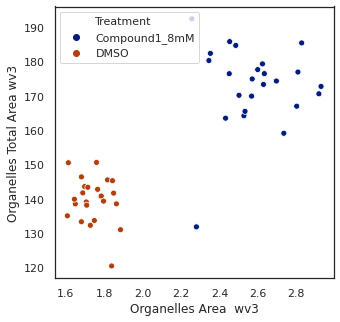

In [61]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (5,5))
ax = sns.scatterplot(x = 'Organelles Area  wv3', y = 'Organelles Total Area wv3',  hue = 'Treatment', data = selected_data)#, palette = ['r', 'b'])
#plt.savefig(path + '//scatter1.png', bbox_inches = 'tight', dpi = 600)
#plt.show()

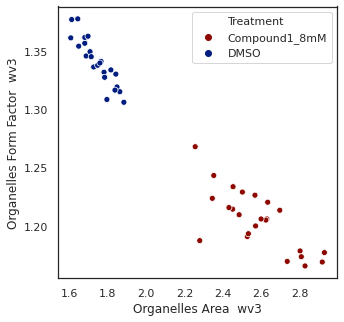

In [62]:
fig = plt.figure(figsize = (5,5))
ax = sns.scatterplot(x = 'Organelles Area  wv3', y = 'Organelles Form Factor  wv3', hue = 'Treatment',
                     data = selected_data, palette = ['r', 'b'])
plt.savefig(path + '//' + 'scatter2.png', bbox_inches = 'tight', dpi = 600)
plt.show()

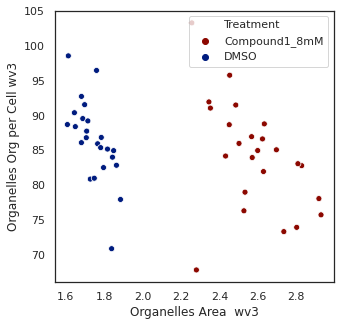

In [63]:
fig = plt.figure(figsize = (5,5))
ax = sns.scatterplot(x = 'Organelles Area  wv3', y = 'Organelles Org per Cell wv3', hue = 'Treatment',
                     data = selected_data, palette = ['r', 'b'])
plt.savefig(path + '//' + 'scatter3.png', bbox_inches = 'tight', dpi = 600)
plt.show()

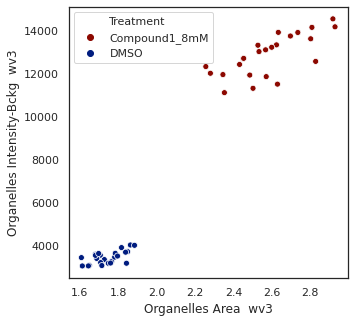

In [64]:
fig = plt.figure(figsize = (5,5))
ax = sns.scatterplot(x = 'Organelles Area  wv3', y = 'Organelles Intensity-Bckg  wv3', hue = 'Treatment',
                     data = selected_data, palette = ['r', 'b'])
plt.savefig(path + '//' + 'scatter4.png', bbox_inches = 'tight', dpi = 600)
plt.show()

#### Explore feature correlation

In [65]:
#print(list(results_well))

In [66]:
Features = ['Cells Area wv2', 'Cells Intensity (Cell) wv2', 'Cells Max Intensity wv2', 'Cells Max height wv2',
            'Cells Max left border wv2', 'Cells Max top border wv2', 'Cells Max width wv2', 'Nuclei Area wv1', 
            'Nuclei Intensity wv1', 'Nuclei Max Intensity wv1', 'Nuclei Max height wv1', 
            'Nuclei Max left border wv1', 'Nuclei Max top border wv1', 'Nuclei Max width wv1', 
            'Organelles Area  wv3', 'Organelles Chord Ratio wv3', 'Organelles Compactness wv3', 
            'Organelles Distance to Nuc  wv3', 'Organelles Elongation  wv3', 'Organelles Form Factor  wv3',
            'Organelles Gyration Radius  wv3', 'Organelles Intensity CV wv3',
            'Organelles Intensity Spreading wv3', 'Organelles Intensity wv3', 'Organelles Intensity-Bckg  wv3',
            'Organelles Intensity_Global Bckg  wv3', 'Organelles Neighbor Count  wv3', 
            'Organelles Org per Cell wv3', 'Organelles Organelle_Bckg Intensity  wv3', 
            'Organelles Organelle_Cyto Intensity wv3', 'Organelles Spacing  wv3', 'Organelles Total Area wv3',
            'Organelles Total Intensity  wv3', 'Organelles Total Intensity-Bckg wv3', 'org_int_area']


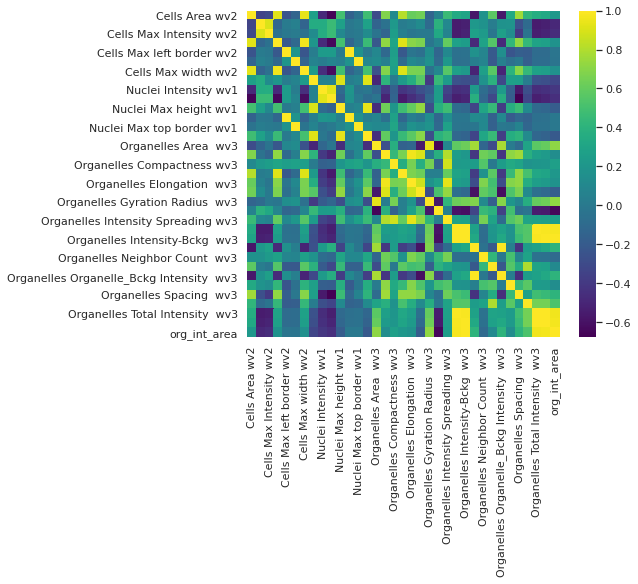

In [67]:
corr = results_well.loc[:, Features].corr()
ax = sns.heatmap(corr, cmap ='viridis')
fig = ax.get_figure()
fig.set_size_inches(7, 6)
fig.savefig(path + '//correlogram.png', bbox_inches='tight', dpi=600)
plt.show()

### PCA 
<a id="pca"></a>

<div align="justify"> So far we have a lot of variables describing nuclei, cells, and organelles (mitochondria), and those variables are partly correlated. The next question we might ask is “How can we reduce the number of relationships between variables and focus on only a few of them?” In PCA, we create new independent variables (Principal Components) from a combination of our “old” variables. However, we create these new independent variables in a specific way and order these new variables by how well they predict our dependent variable (wells with activated mitochondria versus wells with not activated mitochondria).</div>

<div align="justify"> We will run PCA for treatment with the best Z-factor (Compound1_8mM) to visualize 'phenotypic distance' between the two populations of cells with different treatments.</div>

In [68]:
display(selected_data.head())

,Cells Area wv2,Cells Intensity (Cell) wv2,Cells Max Intensity wv2,Cells Max height wv2,Cells Max left border wv2,Cells Max top border wv2,Cells Max width wv2,Nuclei Area wv1,Nuclei Intensity wv1,Nuclei Max Intensity wv1,...,Organelles Organelle_Bckg Intensity wv3,Organelles Organelle_Cyto Intensity wv3,Organelles Spacing wv3,Organelles Total Area wv3,Organelles Total Intensity wv3,Organelles Total Intensity-Bckg wv3,Well,Treatment,Status,org_int_area
7,1853.066874,8574.129650,26106.750000,170.012712,1064.927966,897.506356,172.243644,206.184252,682.942628,1190.949153,...,10.164601,1.194873,3.313107,164.254707,2.365211e+06,2.123456e+06,A17,Compound1_8mM,Positive,33575.530445
8,1916.556553,9590.626520,28237.265849,173.439673,964.674847,953.541922,174.527607,210.704163,707.913976,1231.887526,...,9.366031,1.217377,3.425097,176.483391,2.375097e+06,2.094381e+06,A18,Compound1_8mM,Positive,31040.953360
23,1930.502014,9664.168907,27029.473829,175.757576,1004.873278,944.449036,171.887052,226.678815,639.089828,1107.079890,...,8.567939,1.096854,3.191599,131.907002,1.847806e+06,1.626112e+06,B17,Compound1_8mM,Positive,27319.406582
37,1993.842461,11102.607051,32513.457627,180.978208,932.263923,860.484262,180.697337,215.436126,546.075375,957.171913,...,11.004037,1.178233,3.269203,165.524094,2.273843e+06,2.058905e+06,C17,Compound1_8mM,Positive,32904.079483
38,1996.500697,9702.554423,29105.128968,179.706349,938.841270,903.791667,178.545635,211.253144,568.246682,978.488095,...,9.319383,1.204897,3.276090,180.311306,2.356076e+06,2.092363e+06,C18,Compound1_8mM,Positive,27958.870271


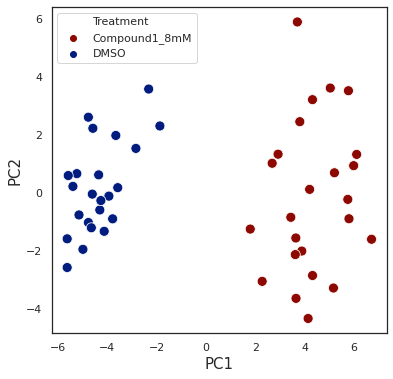

[0.57060605 0.12848969]
Variance explained:  0.6990957377430832


In [69]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pca_data = selected_data
x = pca_data.loc[:, Features].values
y = pca_data.loc[:,['Treatment']].values
x = StandardScaler().fit_transform(x)
pca = PCA(n_components = 2)
    
principalComponents = pca.fit_transform(x)
pca_out = pd.DataFrame(principalComponents, columns = ['PC1', 'PC2'])
pca_out['Treatment'] = pca_data.Treatment.values

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
colors = ['r', 'b']
ax = sns.scatterplot('PC1', 'PC2', data = pca_out, hue = 'Treatment', palette = colors, s = 100)
    
plt.savefig(path + '//Compound1_8mM_PCA_well.png', bbox_inches = 'tight', dpi = 600)
plt.show()
plt.close()
print(pca.explained_variance_ratio_ )
print( 'Variance explained: ', pca.explained_variance_ratio_.cumsum()[-1])

<div align="justify"> We can see that PC1 explains 57% of the total variance, and there is a nice separation between the treatments by PC1. That means PCA has successfully found linear combinations of the features that separate different clusters corresponding to activated versus not activated mitochondria (Compound1_8mM versus DMSO). Let's plot the feature importance for the components.</div>

#### Plot feature importance for Compound1_8mM

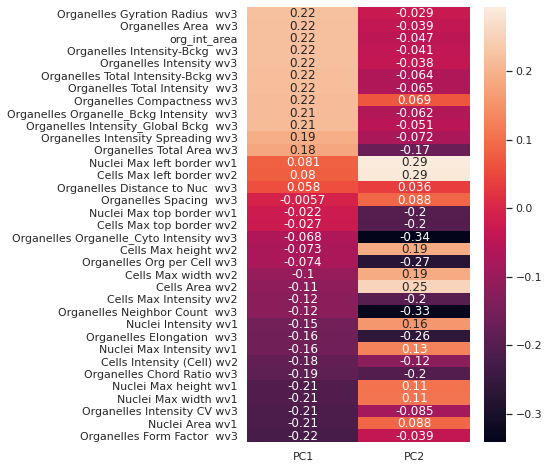

In [70]:
components = pd.DataFrame(pca.components_, columns = Features, index=['PC1', 'PC2'])

fig = plt.figure(figsize = (5, 8))
sns.heatmap(components.transpose().sort_values(['PC1'], ascending = False), annot=True)
plt.savefig(path + '//' + 'feature_heatmap_well.png', bbox_inches = 'tight', dpi = 600)
plt.show()

<div align="justify"> PCA is built upon the assumption that more variability in a particular direction correlates with explaining the behavior of the dependent variable (in our case mitochondria activation). This analysis confirms that the greatest source of variability in our data is associated with organelles descriptors. </div>

### Generate by Field Data

In [71]:
print(Features)

['Cells Area wv2', 'Cells Intensity (Cell) wv2', 'Cells Max Intensity wv2', 'Cells Max height wv2', 'Cells Max left border wv2', 'Cells Max top border wv2', 'Cells Max width wv2', 'Nuclei Area wv1', 'Nuclei Intensity wv1', 'Nuclei Max Intensity wv1', 'Nuclei Max height wv1', 'Nuclei Max left border wv1', 'Nuclei Max top border wv1', 'Nuclei Max width wv1', 'Organelles Area  wv3', 'Organelles Chord Ratio wv3', 'Organelles Compactness wv3', 'Organelles Distance to Nuc  wv3', 'Organelles Elongation  wv3', 'Organelles Form Factor  wv3', 'Organelles Gyration Radius  wv3', 'Organelles Intensity CV wv3', 'Organelles Intensity Spreading wv3', 'Organelles Intensity wv3', 'Organelles Intensity-Bckg  wv3', 'Organelles Intensity_Global Bckg  wv3', 'Organelles Neighbor Count  wv3', 'Organelles Org per Cell wv3', 'Organelles Organelle_Bckg Intensity  wv3', 'Organelles Organelle_Cyto Intensity wv3', 'Organelles Spacing  wv3', 'Organelles Total Area wv3', 'Organelles Total Intensity  wv3', 'Organelles

In [72]:
descriptors = data[['Well', 'Field', 'Treatment','Status']]
Features = Features[:-2]
Features.append('Field')
measurements = data[Features]
results_field = pd.DataFrame()
for name, group in measurements.groupby('Field'):
    m = group.mean()
    m['Field'] = name
    results_field = results_field.append(m, ignore_index = True)

results_field = pd.merge(results_field.copy(), descriptors.drop_duplicates(), how = 'left', on = 'Field')
print(results_field.shape)
display(results_field.head())

(1919, 37)


,Cells Area wv2,Cells Intensity (Cell) wv2,Cells Max Intensity wv2,Cells Max height wv2,Cells Max left border wv2,Cells Max top border wv2,Cells Max width wv2,Field,Nuclei Area wv1,Nuclei Intensity wv1,...,Organelles Neighbor Count wv3,Organelles Org per Cell wv3,Organelles Organelle_Bckg Intensity wv3,Organelles Organelle_Cyto Intensity wv3,Organelles Spacing wv3,Organelles Total Area wv3,Organelles Total Intensity wv3,Well,Treatment,Status
0,1699.631736,16427.124921,44433.811966,169.547009,900.427350,1055.230769,160.606838,A10_1,232.431875,921.149461,...,4.041048,85.700855,6.866880,1.382795,3.128306,142.900694,954661.713146,A10,Compound2_1nM,Sample
1,1932.840929,15636.288119,43586.000000,169.214286,603.557143,725.871429,188.257143,A10_2,247.835482,889.895522,...,3.871522,98.771429,6.425620,1.269944,3.080637,168.693687,761940.805088,A10,Compound2_1nM,Sample
2,1889.446924,17983.235676,46014.235294,165.333333,1197.372549,988.372549,192.098039,A10_3,239.603064,854.724669,...,3.829384,91.862745,6.919986,1.270973,3.277417,160.989069,858777.145846,A10,Compound2_1nM,Sample
3,2069.114746,13834.505672,36514.504065,193.975610,1007.162602,960.089431,181.788618,A10_4,269.600513,831.790345,...,3.798949,85.276423,5.429770,1.208208,3.064705,157.645742,913872.202961,A10,Compound2_1nM,Sample
4,1917.177100,15190.404254,40457.312925,183.047619,1005.204082,1023.088435,169.836735,A10_5,244.661990,833.618367,...,3.675946,69.965986,5.236835,1.165282,3.330111,134.783967,928434.611131,A10,Compound2_1nM,Sample


#### Run by field statistics on selected features

In [73]:
Compound1_8mM = results_field[results_field.Treatment == 'Compound1_8mM'].copy()
Compound1_5mM = results_field[results_field.Treatment == 'Compound1_5mM'].copy()
Compound1_2mM = results_field[results_field.Treatment == 'Compound1_2mM'].copy()
Compound2_30nM = results_field[results_field.Treatment == 'Compound2_30nM'].copy()
Compound2_10nM = results_field[results_field.Treatment == 'Compound2_10nM'].copy()
Compound2_1nM = results_field[results_field.Treatment == 'Compound2_1nM'].copy()
Compound3_8uM = results_field[results_field.Treatment == 'Compound3_8uM'].copy()
Compound3_5uM = results_field[results_field.Treatment == 'Compound3_5uM'].copy()
Compound3_2uM = results_field[results_field.Treatment == 'Compound3_2uM'].copy()
DMSO = results_field[results_field.Treatment == 'DMSO'].copy()

Treatments = [Compound1_8mM, Compound1_5mM, Compound1_2mM, Compound2_30nM, Compound2_10nM, Compound2_1nM,
             Compound3_8uM, Compound3_5uM, Compound3_2uM]

# Cahnge status
DMSO['Status'] = 'Negative'

for t in Treatments:
    t['Status'] = 'Positive' 

print(Compound1_8mM.shape)
#display(Compound1_8mM.head())

(192, 37)


In [74]:
selected_features = ['Organelles Intensity-Bckg  wv3', 'Organelles Area  wv3',
                     'Organelles Form Factor  wv3', 'Organelles Org per Cell wv3',
                     'Organelles Total Area wv3']

#calculate statisticss
all_stat = pd.DataFrame()

for t in Treatments:
    current_data = t.append(DMSO)
    current_data.name = current_data['Treatment'].values[0]
    for f in selected_features:
            stat = sd.sum_statistics(df =  current_data, feature = f)
            stat['Treatment'] = current_data.name
            all_stat = all_stat.append(stat)
all_stat.to_csv(path + '//sum_statistics_field.csv', index = False)
all_stat = all_stat[['Treatment', 'Feature', 'Status', 'size', 'mean', 'std', 'var', 'Z_factor', 'SB']]

all_stat = all_stat.sort_values('Z_factor', ascending  = False)
display(all_stat[0:15])

,Treatment,Feature,Status,size,mean,std,var,Z_factor,SB
0,Compound1_8mM,Organelles Intensity-Bckg wv3,Negative,192.0,3423.737295,786.640702,6.188036e+05,-0.081963,3.602914
1,Compound1_8mM,Organelles Intensity-Bckg wv3,Positive,192.0,12335.429432,2427.398416,5.892263e+06,-0.081963,3.602914
0,Compound1_5mM,Organelles Intensity-Bckg wv3,Negative,192.0,3423.737295,786.640702,6.188036e+05,-0.359629,2.701581
1,Compound1_5mM,Organelles Intensity-Bckg wv3,Positive,192.0,9249.502462,1853.652269,3.436027e+06,-0.359629,2.701581
0,Compound1_8mM,Organelles Area wv3,Negative,192.0,1.734654,0.182620,3.335014e-02,-1.472326,1.439330
1,Compound1_8mM,Organelles Area wv3,Positive,192.0,2.496739,0.445421,1.984001e-01,-1.472326,1.439330
1,Compound1_2mM,Organelles Intensity-Bckg wv3,Positive,192.0,5733.018447,1187.634511,1.410476e+06,-1.564792,1.674491
0,Compound1_2mM,Organelles Intensity-Bckg wv3,Negative,192.0,3423.737295,786.640702,6.188036e+05,-1.564792,1.674491
0,Compound2_10nM,Organelles Form Factor wv3,Negative,192.0,1.343586,0.046152,2.129985e-03,-1.826941,0.928750
1,Compound2_10nM,Organelles Form Factor wv3,Positive,192.0,1.247855,0.044057,1.940995e-03,-1.826941,0.928750


#### PCA  for Compound1  treatment by field

In [75]:
Treatments = [Compound1_2mM, Compound1_5mM, Compound1_8mM]

In [76]:
print(Features)

['Cells Area wv2', 'Cells Intensity (Cell) wv2', 'Cells Max Intensity wv2', 'Cells Max height wv2', 'Cells Max left border wv2', 'Cells Max top border wv2', 'Cells Max width wv2', 'Nuclei Area wv1', 'Nuclei Intensity wv1', 'Nuclei Max Intensity wv1', 'Nuclei Max height wv1', 'Nuclei Max left border wv1', 'Nuclei Max top border wv1', 'Nuclei Max width wv1', 'Organelles Area  wv3', 'Organelles Chord Ratio wv3', 'Organelles Compactness wv3', 'Organelles Distance to Nuc  wv3', 'Organelles Elongation  wv3', 'Organelles Form Factor  wv3', 'Organelles Gyration Radius  wv3', 'Organelles Intensity CV wv3', 'Organelles Intensity Spreading wv3', 'Organelles Intensity wv3', 'Organelles Intensity-Bckg  wv3', 'Organelles Intensity_Global Bckg  wv3', 'Organelles Neighbor Count  wv3', 'Organelles Org per Cell wv3', 'Organelles Organelle_Bckg Intensity  wv3', 'Organelles Organelle_Cyto Intensity wv3', 'Organelles Spacing  wv3', 'Organelles Total Area wv3', 'Organelles Total Intensity  wv3', 'Field']


Compound1_2mM


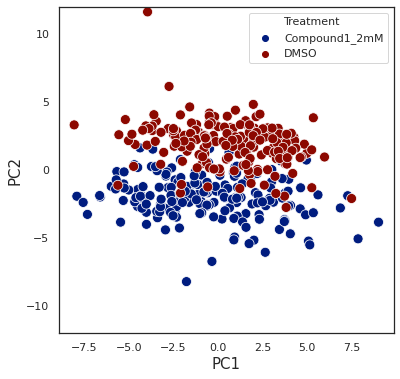

[0.28049211 0.19065904]
Variance explained:  0.4711511527092007
Compound1_5mM


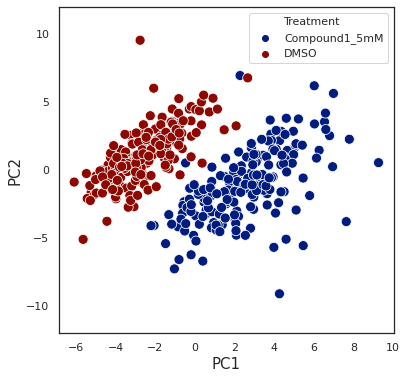

[0.30593855 0.20278818]
Variance explained:  0.5087267271094704
Compound1_8mM


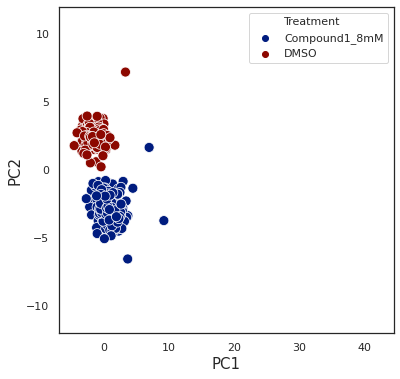

[0.37373136 0.25902428]
Variance explained:  0.632755641306677


In [77]:
Features = Features[:-1]

for t in Treatments:
    current_data = t.append(DMSO)
    current_data.name = current_data['Treatment'].values[0]
    print(current_data.name)
    
    pca_data = current_data
    x = pca_data.loc[:, Features].values
    y = pca_data.loc[:,['Treatment']].values
    x = StandardScaler().fit_transform(x)
    pca = PCA(n_components = 2)
    
    principalComponents = pca.fit_transform(x)
    pca_out = pd.DataFrame(principalComponents, columns = ['PC1', 'PC2'])
    pca_out['Treatment'] = current_data.Treatment.values

    fig = plt.figure(figsize = (6,6))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('PC1', fontsize = 15)
    ax.set_ylabel('PC2', fontsize = 15)
    ax.set_ylim(-12,12)
    colors = [ 'b','r']
    ax = sns.scatterplot('PC1', 'PC2', data = pca_out, hue = 'Treatment', palette = colors, s = 100)
    
    plt.savefig(path + '//' + current_data.name + '_PCA_field.png', bbox_inches = 'tight', dpi = 600)
    plt.show()
    plt.close()
    print(pca.explained_variance_ratio_ )
    print( 'Variance explained: ', pca.explained_variance_ratio_.cumsum()[-1])

#### Plot feature importance

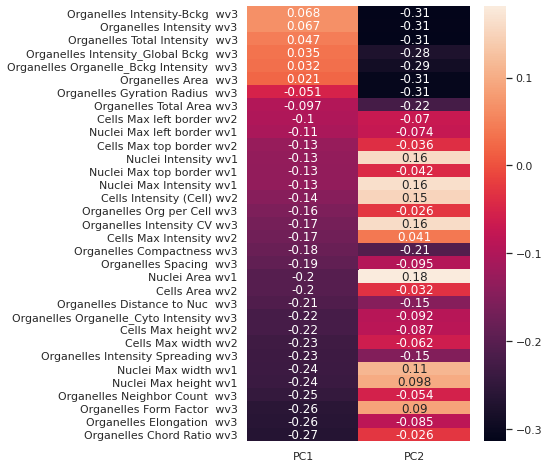

In [78]:
components = pd.DataFrame(pca.components_, columns = Features, index=['PC1', 'PC2'])

fig = plt.figure(figsize = (5, 8))
sns.heatmap(components.transpose().sort_values(['PC1'], ascending = False), annot=True)
plt.savefig(path + '//' + 'feature_heatmap_field.png', bbox_inches = 'tight', dpi = 600)
plt.show()

### Bath Effect
<a id="batch"></a>

<div align="justify"> Discussion about phenotypic assay will be incomplete without mentioning the batch effect. So far we performed assay development with data from one experiment. However, it is important to verify the findings (PCA, models) using data from other independent experiments. To illustrate the batch effect, we will use another by well phenotypic data set containing 6 independent experiments (6 plates). Each plate contains primary culture obtained from skin fibroblasts of two healthy control individuals (HC), and two individuals with disease (DS). As previously, we perform PCA to visualize the phenotypic distance between healthy and affected cells, and plot the results with coloring by a patient, and then by plate.  </div>

In [79]:
bath_data = pd.read_csv('hts_data//bath_data.csv')
print('Data shape: ', bath_data.shape)
print('Plates: ', bath_data.Plate.unique())
print('Patients: ', bath_data.Patient.unique())
display(bath_data.head())

Data shape:  (1675, 43)
Plates:  ['plate_1' 'plate_2' 'plate_3' 'plate_4' 'plate_5' 'plate_6']
Patients:  ['HC_1' 'HC_2' 'DS_1' 'DS_2']


,Patient,Group,Plate,Well,CELL COUNT,NUCLEAR AREA MEAN,NUCLEAR DXA MEAN,NUCLEAR FORM FACTOR MEAN,NUCLEAR INTENSITIY MEAN,NUCLEAR PARIMETER MEAN,...,median MITO FORM FACTOR,median MITO INTENSITY,TMRE AREA MEAN,TMRE DXA MEAN,TMRE FORM FACTOR MEAN,TMRE INTENSITY MEAN,median TMRE AREA,median TMRE DXA,median TMRE FORM FACTOR,median TMRE INTENSITY
0,HC_1,HC,plate_1,A17,350,181.438,142857.784,0.896,790.207,50.254,...,0.963,18337.546,163.001,126137.838,1.235,61262.774,146.768,109683.596,1.238,56865.926
1,HC_1,HC,plate_1,B17,311,184.944,160176.168,0.895,870.619,50.778,...,0.933,15018.349,239.108,180390.787,1.307,93496.370,220.971,164007.031,1.316,81922.210
2,HC_1,HC,plate_1,C17,284,186.056,154166.188,0.894,838.111,50.960,...,0.955,15731.877,141.096,106257.978,1.270,67781.854,116.876,84228.012,1.272,61969.594
3,HC_1,HC,plate_1,D17,261,185.813,157740.760,0.896,848.841,50.809,...,0.964,18136.066,149.302,109356.482,1.294,87089.576,132.984,96722.052,1.300,80102.282
4,HC_1,HC,plate_1,E17,291,183.303,156335.326,0.892,852.985,50.697,...,1.004,14566.026,116.756,86466.112,1.293,73072.673,99.606,71637.217,1.291,66992.605


In [80]:
Features = list(bath_data)[5:]
print(Features)

['NUCLEAR AREA MEAN', 'NUCLEAR DXA MEAN', 'NUCLEAR FORM FACTOR MEAN', 'NUCLEAR INTENSITIY MEAN', 'NUCLEAR PARIMETER MEAN', 'NUCLEAR WRMI MEAN', 'median NUCLEAR AREA', 'median NUCLEAR DXA', 'median NUCLEAR FORM FACTOR', 'median NUCLEAR INTENSITY', 'median NUCLEAR PARIMETER', 'median NUCLEAR WRMI', 'CELL AREA MEAN', 'CELL DXA MEAN', 'CELL FORM FACTOR MEAN', 'CELL INTINSITY MEAN', 'CELL PARIEMETER MEAN', 'median CELL AREA', 'median CELL DXA', 'median CELL FORM FACTOR', 'median CELL INTINSITY', 'median CELL PARIMETER', 'MITOTRACKER AREA', 'MITOTRACKER DXA MEAN', 'MITOTRACKER FORM FACTOR MEAN', 'MITOTRACKER INTENSITY MEAN', 'median MITO AREA', 'median MITO DXA', 'median MITO FORM FACTOR', 'median MITO INTENSITY', 'TMRE AREA MEAN', 'TMRE DXA MEAN', 'TMRE FORM FACTOR MEAN', 'TMRE INTENSITY MEAN', 'median TMRE AREA', 'median TMRE DXA', 'median TMRE FORM FACTOR', 'median TMRE INTENSITY']


#### PCA

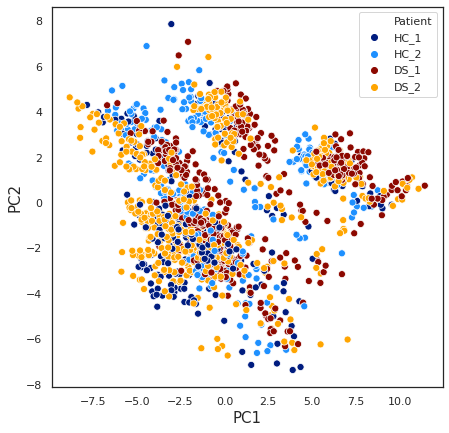

[0.38719297 0.17848237]
Variance explained:  0.5656753406329096


In [81]:
pca_data = bath_data
x = pca_data.loc[:, Features].values
y = pca_data.loc[:,['Group']].values
x = StandardScaler().fit_transform(x)
pca = PCA(n_components = 2)
    
principalComponents = pca.fit_transform(x)
pca_out = pd.DataFrame(principalComponents, columns = ['PC1', 'PC2'])
pca_out['Plate'] = pca_data.Plate.values
pca_out['Patient'] = pca_data.Patient.values
pca_out['Group'] = pca_data.Group.values

fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
colors = [ 'b', 'dodgerblue', 'r', 'orange']
ax = sns.scatterplot('PC1', 'PC2', data = pca_out, hue = 'Patient', palette = colors, s = 50)
    
plt.savefig(path + '//' + current_data.name + '_PCA_patient.png', bbox_inches = 'tight', dpi = 600)
plt.show()
plt.close()
print(pca.explained_variance_ratio_ )
print( 'Variance explained: ', pca.explained_variance_ratio_.cumsum()[-1])

#### Now plot colored by experiment (plate)

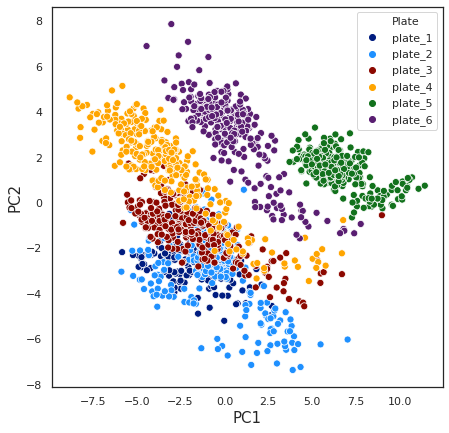

In [82]:
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
colors = [ 'b', 'dodgerblue', 'r', 'orange', 'g', 'm']
ax = sns.scatterplot('PC1', 'PC2', data = pca_out, hue = 'Plate', palette = colors, s = 50)
    
plt.savefig(path + '//' + current_data.name + '_PCA_patient.png', bbox_inches = 'tight', dpi = 600)
plt.show()
plt.close()

<div align="justify"> As we can see, the batch effect inserts a much stronger source of variation than the differences between healthy versus affected cells. Hence, such an assay should be reconsidered.</div>

#### Create ppt ant html reports and clean output folder

In [84]:
report = sd.create_presentation(path).save(path +'//' + 'image_assay_dev_report.pptx')

In [85]:
# Save notebook as html for reporting
! jupyter nbconvert --to html 04b_imaging_assay_development.ipynb

[NbConvertApp] Converting notebook 04b_imaging_assay_development.ipynb to html
[NbConvertApp] Writing 3522338 bytes to 04b_imaging_assay_development.html


In [86]:
# Clean pictures from output folder
for f in os.listdir(path):
    if '.png' in f:
        os.remove(path +'//' + f)

### Conclusions
<a id="conclusions"></a>

* PCA can be used to ensure that greatest sources of variance in the data related to desired direction (in our cases, changes in organelles behavior).

* We can conclude that in our case by well data are more robust than by field data and provides Z-factor suitable for screening.

* Always consider Batch effect in assay development.